In [21]:
import pandas as pd
import random
import uuid
from faker import Faker

fake = Faker("en_IN")

STATES = [
    "Maharashtra","Delhi","Tamil Nadu","Uttar Pradesh","Gujarat",
    "Karnataka","Rajasthan","West Bengal","Punjab","Haryana",
    "Telangana","Andhra Pradesh","Chhattisgarh","Odisha","Bihar",
    "Jharkhand","Assam","Goa","Manipur","Meghalaya","Mizoram",
    "Nagaland","Sikkim","Tripura"
]

DISPUTE_TYPES = [
    "invoice_non_payment",
    "interest_on_delay",
    "goods_rejection",
    "short_payment",
    "service_non_payment",
    "others"
]

DOCUMENTS = [
    "invoice",
    "purchase_order",
    "delivery_challan",
    "email_correspondence"
]

def generate_case():
    claim = round(random.uniform(50_000, 5_000_000), 2)
    delay_days = random.randint(46, 800)
    docs = random.sample(DOCUMENTS, k=random.randint(1, 4))
    doc_score = round(len(docs) / 4, 2)

    if claim < 500_000:
        weights = [0.45, 0.15, 0.05, 0.35]
    elif claim < 2_000_000:
        weights = [0.30, 0.25, 0.10, 0.35]
    else:
        weights = [0.15, 0.35, 0.20, 0.30]

    outcomes = ["settlement", "award_in_favor", "rejected", "pending"]
    outcome = random.choices(outcomes, weights=weights)[0]

    settle_min = settle_max = None
    if outcome == "settlement":
        settle_min = round(random.uniform(0.70, 0.85), 2)
        settle_max = round(random.uniform(settle_min, 0.95), 2)

    return {
        "case_id": f"SYN_{uuid.uuid4().hex[:10]}",
        "dispute_type": random.choice(DISPUTE_TYPES),
        "claim_amount": claim,
        "delay_days": delay_days,
        "document_count": len(docs),
        "document_completeness_score": doc_score,
        "jurisdiction": random.choice(STATES),
        "final_outcome": outcome,
        "settlement_min_ratio": settle_min,
        "settlement_max_ratio": settle_max,
        "is_settlement": 1 if outcome == "settlement" else 0
    }

# Generate dataset
N = 12000
data = [generate_case() for _ in range(N)]

with open("msme_synthetic_cases.json", "w") as f:
    import json
    json.dump(data, f, indent=2)

print("✅ JSON dataset generated:", len(data))


✅ JSON dataset generated: 12000


# Traiing cell

In [24]:
import json
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier

# Load JSON
with open("msme_synthetic_cases.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Encode categorical fields
dispute_encoder = LabelEncoder()
state_encoder = LabelEncoder()
df["dispute_type_enc"] = dispute_encoder.fit_transform(df["dispute_type"])
df["jurisdiction_enc"] = state_encoder.fit_transform(df["jurisdiction"])

FEATURES = [
    "claim_amount",
    "delay_days",
    "document_count",
    "document_completeness_score",
    "dispute_type_enc",
    "jurisdiction_enc"
]

X = df[FEATURES]
y = df["is_settlement"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.3).astype(int)
joblib.dump(model, "xgb_model.pkl")
joblib.dump(dispute_encoder, "dispute_encoder.pkl")
joblib.dump(state_encoder, "state_encoder.pkl")
print("Model saved as xgb_model.pkl")
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))
print(classification_report(y_test, y_pred))


Model saved as xgb_model.pkl
ROC-AUC: 0.607
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1867
           1       0.34      0.32      0.33       533

    accuracy                           0.71      2400
   macro avg       0.58      0.57      0.57      2400
weighted avg       0.71      0.71      0.71      2400



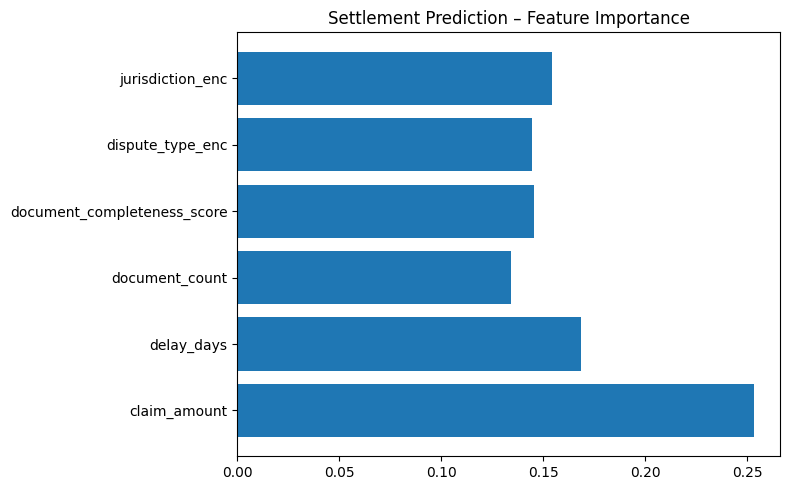

In [25]:
import matplotlib.pyplot as plt

importance = model.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(FEATURES, importance)
plt.title("Settlement Prediction – Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
# Prediction INput